In [2]:
## Import Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import urllib
from urllib.request import urlopen

import nltk   
import bs4 as bs
from sklearn.model_selection import KFold 
from sklearn import linear_model

import re
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 3500)
from sklearn.naive_bayes import ComplementNB

import seaborn as sns
import scattertext as st
import spacy
import wordcloud

## Loading the data

In [3]:
# Importing given data

train = pd.read_csv('10k_filing_info_train_links-1570100710859.csv')

#train=train.loc[train['long_term_outlook'] == 0]

train.head()

train.shape

(2568, 5)

### Data Extraction sample

In [4]:
link='https://www.sec.gov/Archives/edgar/data/1002910/000100291017000054/0001002910-17-000054.txt'
link=re.sub('.txt','-index.html',link)
print(link)

sauce = urllib.request.urlopen(link).read()
soup = bs.BeautifulSoup(sauce,'lxml')

https://www.sec.gov/Archives/edgar/data/1002910/000100291017000054/0001002910-17-000054-index.html


In [12]:
train_text=train
train_text['10k_text']=' '
train_text.head()

,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text
0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,
1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,
2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,
3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,
4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,


In [7]:
link='https://www.sec.gov/Archives/edgar/data/1002910/000100291017000054/0001002910-17-000054.txt'

#### Explanation of the following code:
###### 1) for loop section 1 - Checks if the file format is the pre-2000 version, and simply extracts the relevant 10k document(which is always the first document type attached, hence the "soup.find_all("type")[0])".
###### 2) for loop section 2.1 - Pending conditions, it extracts the table of contents from the index.html page, and finds the 10k file
###### 3) for loop section 2.2 - For any exceptions, simply uses the prior described method to find the 10k documents

In [69]:
%%time
import math
for i in range(1864,2568):
    if(len(train_text.iloc[i,3])<80):
        sauce = urllib.request.urlopen(train_text.iloc[i,3]).read()
        soup = bs.BeautifulSoup(sauce,'lxml')
        train_text.iloc[i,5]=soup.find_all("type")[0].get_text()
        print(i)
    else:
        link=train_text.iloc[i,3]
        link=re.sub('.txt','-index.html',link)
        dfs=pd.read_html(link)
        table=dfs[0]
        file=table.iloc[0,2]
        #print(table.iloc[0,1])
        if(file!='0001.txt' and file!='0001.htm' and file!='nan'and pd.isnull(file)!=True):
            new_link=re.findall('https://www.sec.gov/Archives/edgar/data/\d*/\d*/',link)
            #print(math.isnan(file))
            final_link=new_link[0]+''+file
            #print(final_link)
            final_link=re.match('https://www.sec.gov/Archives/edgar/data/\d*/\d*/[A-Za-z0-9-_]*.(htm|txt)',final_link)
            #print(final_link[0])
            sauce = urllib.request.urlopen(final_link[0]).read()
            soup = bs.BeautifulSoup(sauce,'lxml')
            train_text.iloc[i,5]=soup.get_text()
            print(i)
        else:
            sauce = urllib.request.urlopen(train_text.iloc[i,3]).read()
            soup = bs.BeautifulSoup(sauce,'lxml')
            train_text.iloc[i,5]=soup.find_all("type")[0].get_text()
            print(i)

In [68]:
#Storing extracted texts locally
train_text.to_csv('training_data_grand_final.csv')

# Cleaning the Training dataset and getting it ready for modeling

### training_data_grand_final.csv obtained by running all prior code

In [3]:
train=pd.read_csv('training_data_grand_final.csv')

In [4]:
train['10k_text'] = [each_text.strip().lower() for each_text in train['10k_text']]
train['word_count'] = [len(each_text.split(' ')) for each_text in train['10k_text']]

### Removing unecessary symbols and single letters

In [5]:
def scrub_words(text):
    # Replace \xao characters in text -
    # \xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160).
    text = re.sub('\xa0', ' ', text)

    # Replace non ascii and digits
    text = re.sub("(\\W|\\d)", ' ', text)

    # Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)

    # Remove html markup
    text = re.sub("<.*?>", ' ', text)
    
    #Remove single characters
    text = re.sub(r"\b[a-zA-Z]\b", '',text)
    
    #Removing special characters
    text = re.sub('[!|~|?|#|&|*|\\(|)]','',text)

    return text

In [6]:
train['10k_text_prelim_clean'] = [scrub_words(each_text) for each_text in train['10k_text']]
train['word_count_prelim_clean'] = [len(each_text.split(' ')) for each_text in train['10k_text_prelim_clean']]

### Removing Stop words

In [7]:
train.head()

,Unnamed: 0,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean
0,0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20131231x10kye.htm\n10-k\n\n\n...,81454,zoetis kye htm zoetis ...,116236
1,1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20151231x10kye.htm\n10-k\n\n\n...,87807,zoetis kye htm tab...,125996
2,2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nyum10k123111.htm\nyum form 10-k\n\n\n...,49652,yum htm yum form yum ...,83365
3,3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,"10-k\n1\nfinalform10k.htm\nyum! brands, inc, 2...",51060,finalform htm yum brands inc f...,106139
4,4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nform10k02.htm\nform 10-k 2002\n\nform...,60471,form htm form form ...,107307


In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['10k_text_no_stopwords'] = train['10k_text_prelim_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train['word_count_no_stopwords'] = [len(each_text.split(' ')) for each_text in train['10k_text_no_stopwords']]
train.head()

,Unnamed: 0,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean,10k_text_no_stopwords,word_count_no_stopwords
0,0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20131231x10kye.htm\n10-k\n\n\n...,81454,zoetis kye htm zoetis ...,116236,zoetis kye htm zoetis ye table contentsunited ...,49653
1,1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20151231x10kye.htm\n10-k\n\n\n...,87807,zoetis kye htm tab...,125996,zoetis kye htm table contentsunited states sec...,53576
2,2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nyum10k123111.htm\nyum form 10-k\n\n\n...,49652,yum htm yum form yum ...,83365,yum htm yum form yum united statessecurities e...,30564
3,3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,"10-k\n1\nfinalform10k.htm\nyum! brands, inc, 2...",51060,finalform htm yum brands inc f...,106139,finalform htm yum brands inc form form united ...,28540
4,4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nform10k02.htm\nform 10-k 2002\n\nform...,60471,form htm form form ...,107307,form htm form form united states securities ex...,30228


## Creating list of words from the finance dictionary

### Filtering out the words only present in the list

In [9]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

In [10]:
%%time
fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter'] = train['10k_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter']]
train.head()

Wall time: 57min 41s


,Unnamed: 0,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean,10k_text_no_stopwords,word_count_no_stopwords,10k_text_finterm_filter,word_count_finterm_filter
0,0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20131231x10kye.htm\n10-k\n\n\n...,81454,zoetis kye htm zoetis ...,116236,zoetis kye htm zoetis ye table contentsunited ...,49653,jurisdiction required required required requir...,4797
1,1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20151231x10kye.htm\n10-k\n\n\n...,87807,zoetis kye htm tab...,125996,zoetis kye htm table contentsunited states sec...,53576,jurisdiction required required required requir...,5287
2,2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nyum10k123111.htm\nyum form 10-k\n\n\n...,49652,yum htm yum form yum ...,83365,yum htm yum form yum united statessecurities e...,30564,jurisdiction required required required requir...,2880
3,3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,"10-k\n1\nfinalform10k.htm\nyum! brands, inc, 2...",51060,finalform htm yum brands inc f...,106139,finalform htm yum brands inc form form united ...,28540,required required jurisdiction required requir...,2222
4,4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nform10k02.htm\nform 10-k 2002\n\nform...,60471,form htm form form ...,107307,form htm form form united states securities ex...,30228,required required jurisdiction required requir...,2821


## Creating buckets for each individual category of words

### Negative

In [12]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Negative']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_neg'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_fillter_neg'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_neg']]

### Litigious

In [13]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Litigious']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_lit'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_lit'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_lit']]

### Positive

In [14]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Positive']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_pos'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_pos'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_pos']]

### Uncertainty

In [15]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Uncertainty']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_unc'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_unc'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_unc']]

### Constraining

In [16]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Constraining']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_const'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_const'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_const']]

### Interesting

In [17]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Interesting']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_interest'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_interest'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_interest']]

### Superfluous

In [18]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Superfluous']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

train['10k_text_finterm_filter_super'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_filter_super'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_super']]

In [39]:
train.head()
train.shape

(2568, 28)

# Cleaning the Testing dataset and getting it ready for modeling

### testing_data_grand_final.csv obtained by running all "Testing Data Collection" code

In [20]:
test=pd.read_csv('testing_data_grand_final.csv')

In [21]:
test['10k_text'] = [each_text.strip().lower() for each_text in test['10k_text']]
test['word_count'] = [len(each_text.split(' ')) for each_text in test['10k_text']]

### Removing unecessary symbols and single letters

In [22]:
def scrub_words(text):
    # Replace \xao characters in text -
    # \xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160).
    text = re.sub('\xa0', ' ', text)

    # Replace non ascii and digits
    text = re.sub("(\\W|\\d)", ' ', text)

    # Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)

    # Remove html markup
    text = re.sub("<.*?>", ' ', text)
    
    #Remove single characters
    text = re.sub(r"\b[a-zA-Z]\b", '',text)
    
    #Removing special characters
    text = re.sub('[!|~|?|#|&|*|\\(|)]','',text)

    return text

In [23]:
test['10k_text_prelim_clean'] = [scrub_words(each_text) for each_text in test['10k_text']]
test['word_count_prelim_clean'] = [len(each_text.split(' ')) for each_text in test['10k_text_prelim_clean']]

### Removing Stop words

In [24]:
test.head()

,Unnamed: 0,id,ticker,cik,filing_date,10k_link,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean
0,0,0,GD,40533,2/17/2012,https://www.sec.gov/Archives/edgar/data/40533/...,10-k\n1\nd271667d10k.htm\nform 10-k\n\nform 10...,40510,htm form form table of...,116728
1,1,1,MTB,36270,3/19/1999,https://www.sec.gov/Archives/edgar/data/36270/...,10-k\n1\n10-k\n\n\n\n\n ...,155421,...,249957
2,2,2,RRC,315852,3/6/2001,https://www.sec.gov/Archives/edgar/data/315852...,10-k\n1\nl86830ae10-k.htm\nrange resources cor...,27444,ae htm range resources corporati...,70365
3,3,3,LH,920148,2/26/2009,https://www.sec.gov/Archives/edgar/data/920148...,10-k\n1\nlabcorp10k.htm\n\n \nunited states\ns...,58431,labcorp htm united states securitie...,105482
4,4,4,SYY,96021,9/16/2004,https://www.sec.gov/Archives/edgar/data/96021/...,10-k\n1\nh18314e10vk.txt\nsysco corporation - ...,90078,vk txt sysco corporation july ...,156207


In [25]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

test['10k_text_no_stopwords'] = test['10k_text_prelim_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['word_count_no_stopwords'] = [len(each_text.split(' ')) for each_text in test['10k_text_no_stopwords']]
train.head()

,Unnamed: 0,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean,...,10k_text_finterm_filter_pos,word_count_finterm_filter_pos,10k_text_finterm_filter_unc,word_count_finterm_filter_unc,10k_text_finterm_filter_const,word_count_finterm_filter_const,10k_text_finterm_filter_interest,word_count_finterm_filter_interest,10k_text_finterm_filter_super,word_count_finterm_filter_super
0,0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20131231x10kye.htm\n10-k\n\n\n...,81454,zoetis kye htm zoetis ...,116236,...,best beneficial enhancing enable effective imp...,667,may risk risk approximately approximately appr...,1468,required required required requirements requir...,581,chapter chapter march increasing increasing in...,143,efficacious efficacy efficacy furthermore effi...,20
1,1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20151231x10kye.htm\n10-k\n\n\n...,87807,zoetis kye htm tab...,125996,...,best efficiency beneficial enhancing enable ef...,736,risk risk approximately approximately approxim...,1528,required required required requirements requir...,628,chapter chapter increasing increasing increase...,141,efficacious efficacy efficacy efficacy further...,27
2,2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nyum10k123111.htm\nyum form 10-k\n\n\n...,49652,yum htm yum form yum ...,83365,...,best effective attractive assure strong improv...,379,may may anticipate believe assumptions predict...,746,required required required requirements requir...,363,secret increases disabled concerning decrease ...,103,furthermore furthermore theses furthermore put...,16
3,3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,"10-k\n1\nfinalform10k.htm\nyum! brands, inc, 2...",51060,finalform htm yum brands inc f...,106139,...,best effective attractive assure strong streng...,305,may may may believes believes may varies depen...,580,required required required required requiremen...,248,secret increases chapter disabled concerning a...,106,bifurcated bifurcated superannuation,3
4,4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nform10k02.htm\nform 10-k 2002\n\nform...,60471,form htm form form ...,107307,...,best effective attractive assure strong streng...,317,may may may may nearly believes believes may v...,651,required required required required requiremen...,326,secret march increases chapter disabled concer...,124,putative putative superannuation,3


## Creating list of words from the finance dictionary

### Filtering out the words only present in the list

In [26]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

In [27]:
%%time
fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter'] = test['10k_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter']]
train.head()

Wall time: 18min 58s


,Unnamed: 0,ticker,cik,filing_date,10k_link,long_term_outlook,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean,...,10k_text_finterm_filter_pos,word_count_finterm_filter_pos,10k_text_finterm_filter_unc,word_count_finterm_filter_unc,10k_text_finterm_filter_const,word_count_finterm_filter_const,10k_text_finterm_filter_interest,word_count_finterm_filter_interest,10k_text_finterm_filter_super,word_count_finterm_filter_super
0,0,ZTS,1555280,3/26/2014,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20131231x10kye.htm\n10-k\n\n\n...,81454,zoetis kye htm zoetis ...,116236,...,best beneficial enhancing enable effective imp...,667,may risk risk approximately approximately appr...,1468,required required required requirements requir...,581,chapter chapter march increasing increasing in...,143,efficacious efficacy efficacy furthermore effi...,20
1,1,ZTS,1555280,2/24/2016,https://www.sec.gov/Archives/edgar/data/155528...,1,10-k\n1\nzoetis-20151231x10kye.htm\n10-k\n\n\n...,87807,zoetis kye htm tab...,125996,...,best efficiency beneficial enhancing enable ef...,736,risk risk approximately approximately approxim...,1528,required required required requirements requir...,628,chapter chapter increasing increasing increase...,141,efficacious efficacy efficacy efficacy further...,27
2,2,YUM,1041061,2/21/2012,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nyum10k123111.htm\nyum form 10-k\n\n\n...,49652,yum htm yum form yum ...,83365,...,best effective attractive assure strong improv...,379,may may anticipate believe assumptions predict...,746,required required required requirements requir...,363,secret increases disabled concerning decrease ...,103,furthermore furthermore theses furthermore put...,16
3,3,YUM,1041061,2/28/2005,https://www.sec.gov/Archives/edgar/data/104106...,1,"10-k\n1\nfinalform10k.htm\nyum! brands, inc, 2...",51060,finalform htm yum brands inc f...,106139,...,best effective attractive assure strong streng...,305,may may may believes believes may varies depen...,580,required required required required requiremen...,248,secret increases chapter disabled concerning a...,106,bifurcated bifurcated superannuation,3
4,4,YUM,1041061,3/11/2003,https://www.sec.gov/Archives/edgar/data/104106...,1,10-k\n1\nform10k02.htm\nform 10-k 2002\n\nform...,60471,form htm form form ...,107307,...,best effective attractive assure strong streng...,317,may may may may nearly believes believes may v...,651,required required required required requiremen...,326,secret march increases chapter disabled concer...,124,putative putative superannuation,3


## Creating buckets for each individual category of words

### Negative

In [28]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Negative']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_neg'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_neg'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_neg']]

### Litigious

In [29]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Litigious']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_lit'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_lit'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_lit']]

### Positive

In [30]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Positive']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_pos'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_pos'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_pos']]

### Uncertainty

In [31]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Uncertainty']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_unc'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_unc'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_unc']]

### Constraining

In [32]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Constraining']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_const'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_const'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_const']]

### Interesting

In [33]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Interesting']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_interest'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_interest'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_interest']]

### Superfluous

In [34]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Superfluous']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()
fin_term_list = fin_dict['Word'].tolist()

test['10k_text_finterm_filter_super'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_filter_super'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_super']]

In [76]:
test.head()
test.shape
test.to_csv('Testing_data_modeling_final.csv')

In [448]:
train.head()
train.shape
train.to_csv('Training_data_modeling_final.csv')

# Calling the prepared datasets

In [28]:
train=pd.read_csv('Training_data_modeling_final.csv')
test=pd.read_csv('Testing_data_modeling_final.csv')

# Model building (0.51 solution)

In [29]:
%%time
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

#[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
#                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()

fin_term_list = fin_dict['Word'].tolist()
                 
train['10k_text_finterm_filter_07'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_07'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_07']]

Wall time: 2min 13s


In [30]:
train_final=train

In [31]:
print(confusion_matrix(train_final.long_term_outlook, train_final.long_term_outlook))

Text_data=train_final['10k_text_finterm_filter_07']
Text_data1 = Text_data.tolist()

X_train, X_test, y_train, y_test=train_test_split(Text_data1,train_final['long_term_outlook'],test_size=0.3,random_state=1234)

#Transforming training data
tfidf_transformer = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

[[ 747    0]
 [   0 1821]]


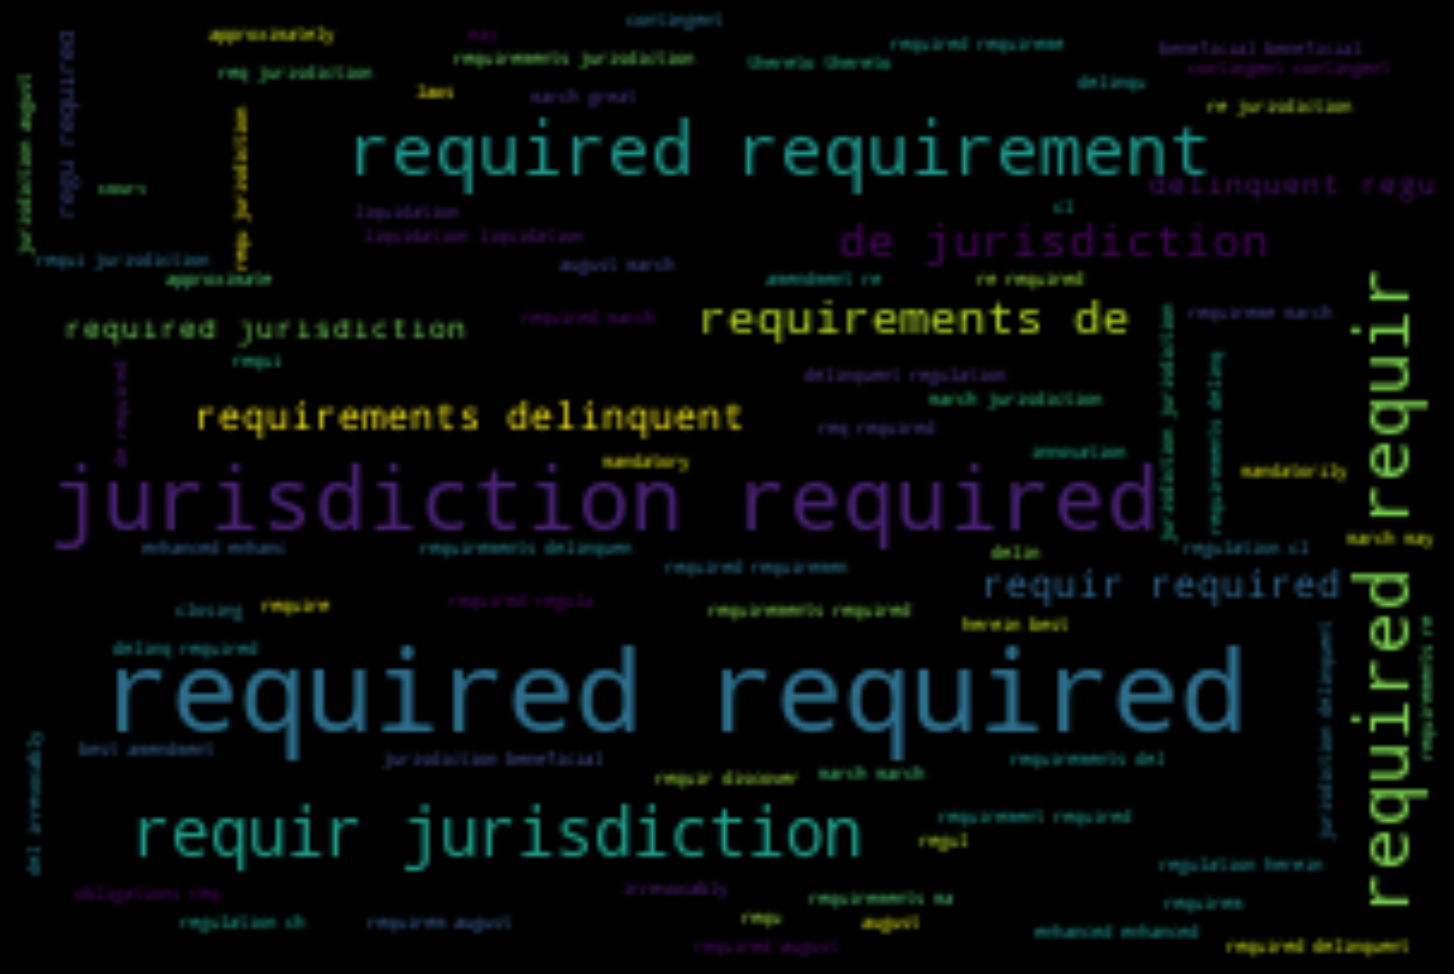

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = train["10k_text_finterm_filter_07"]
wordcloud = WordCloud(
    width = 300,
    height = 200,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [33]:
logreg_train = linear_model.LogisticRegression(class_weight="balanced",solver='newton-cg',random_state=42,penalty='l2',C=0.75)
lr_clf = logreg_train.fit(X_train_tfidf, y_train) #fit logreg model on train data

pred_lr_train=lr_clf.predict(X_train_tfidf) # predict on train data

In [34]:
#Cross Validation on Training and testing
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(lr_clf, X_train_tfidf, y_train, cv=5,scoring='f1_macro')

print("Train_Confusion matrix:\n", confusion_matrix(y_train,pred_lr_train))
print("F1 Score: ",f1_score(y_train, pred_lr_train, average='macro'))
print("Precision: ",precision_score(y_train, pred_lr_train, average='macro'))
print("Recall: ",recall_score(y_train, pred_lr_train, average='macro'))


y_preds=lr_clf.predict(X_test_tfidf)
print('Testing Score:',f1_score(y_test, y_preds, average='macro'))
print('\n')
#Cross Validation on Training and testing
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(lr_clf, X_train_tfidf, y_train, cv=5,scoring='f1_macro')
print('Training Scores K fold:')
print(scores_lr)
print('Mean score of K-folds:',scores_lr.mean())

Train_Confusion matrix:
 [[446  95]
 [289 967]]
F1 Score:  0.7666997546798802
Precision:  0.758674430224067
Recall:  0.797151859613596
Testing Score: 0.548684636761973


Training Scores K fold:
[0.52895172 0.55642373 0.46787786 0.54279402 0.49700439]
Mean score of K-folds: 0.5186103452121866


# Model building (0.52 Solution)

In [35]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Litigious']==1)|(fin_dict['Constraining']==1)]

#[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
#                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()

fin_term_list = fin_dict['Word'].tolist()


train['10k_text_finterm_filter_07'] = train['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
train['word_count_finterm_07'] = [len(each_text.split(' ')) for each_text in train['10k_text_finterm_filter_07']]

In [36]:
train_final=train

In [37]:
Text_data=train_final['10k_text_finterm_filter_07']
Text_data1 = Text_data.tolist()

X_train, X_test, y_train, y_test=train_test_split(Text_data1,train_final['long_term_outlook'],test_size=0.3,random_state=1234)

#Transforming training data
tfidf_transformer = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

In [45]:
logreg_train = linear_model.LogisticRegression(class_weight="balanced",solver='newton-cg',random_state=42,penalty='l2',C=0.75)
lr_clf = logreg_train.fit(X_train_tfidf, y_train) #fit logreg model on train data

pred_lr_train=lr_clf.predict(X_train_tfidf) # predict on train data

print("Train_Confusion matrix:\n", confusion_matrix(y_train,pred_lr_train))

print("F1 Score: ",f1_score(y_train, pred_lr_train, average='macro'))
print("Precision: ",precision_score(y_train, pred_lr_train, average='macro'))
print("Recall: ",recall_score(y_train, pred_lr_train, average='macro'))


y_preds=lr_clf.predict(X_test_tfidf)
print('Testing Score:',f1_score(y_test, y_preds, average='macro'))
print('\n')
#Cross Validation on Training and testing
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(lr_clf, X_train_tfidf, y_train, cv=5,scoring='f1_macro')
print('Training Scores K fold:')
print(scores_lr)
print('Mean score of K-folds:',scores_lr.mean())

Train_Confusion matrix:
 [[407 134]
 [345 911]]
F1 Score:  0.7106866680581732
Precision:  0.7064968695917744
Recall:  0.738814503690971
Testing Score: 0.537638572698852


Training Scores K fold:
[0.50893051 0.53580634 0.54469359 0.56669227 0.51821029]
Mean score of K-folds: 0.5348665985585488


# Scoring on the testing data

In [39]:
fin_dict=pd.read_csv('finance_word_dictionary-1570171303593.csv')
fin_dict=fin_dict.loc[(fin_dict['Litigious']==1)|(fin_dict['Constraining']==1)]

#[(fin_dict['Negative']==1)|(fin_dict['Uncertainty']==1)|(fin_dict['Positive']==1)|(fin_dict['Litigious']==1)|
#                      (fin_dict['Constraining']==1)|(fin_dict['Superfluous']==1)|(fin_dict['Interesting']==1)]

fin_dict['Word']=fin_dict['Word'].str.lower()

fin_term_list = fin_dict['Word'].tolist()


test['10k_text_finterm_filter_07'] = test['10k_text_finterm_filter'].apply(lambda x: ' '.join([word for word in x.split() if word in (fin_term_list)]))
test['word_count_finterm_07'] = [len(each_text.split(' ')) for each_text in test['10k_text_finterm_filter_07']]

In [40]:
test.head()

,Unnamed: 0,Unnamed: 0.1,id,ticker,cik,filing_date,10k_link,10k_text,word_count,10k_text_prelim_clean,word_count_prelim_clean,10k_text_no_stopwords,word_count_no_stopwords,10k_text_finterm_filter,word_count_finterm_filter,10k_text_finterm_filter_neg,word_count_finterm_fillter_neg,10k_text_finterm_filter_lit,word_count_finterm_filter_lit,10k_text_finterm_filter_pos,word_count_finterm_filter_pos,10k_text_finterm_filter_unc,word_count_finterm_filter_unc,10k_text_finterm_filter_const,word_count_finterm_filter_const,10k_text_finterm_filter_interest,word_count_finterm_filter_interest,10k_text_finterm_filter_super,word_count_finterm_filter_super,10k_text_finterm_filter_07,word_count_finterm_07
0,0,0,0,GD,40533,2/17/2012,https://www.sec.gov/Archives/edgar/data/40533/...,10-k\n1\nd271667d10k.htm\nform 10-k\n\nform 10...,40510,htm form form table of...,116728,htm form form table contents united states sec...,25680,jurisdiction required required required requir...,2057,delinquent closing unresolved disagreements di...,405,jurisdiction regulation regulation herein amen...,568,best beneficial integrity superior improvement...,357,risk risk nearly varying approximately approxi...,468,required required required requirements requir...,235,chapter increasing increasing bridge reduction...,104,nonetheless,1,jurisdiction required required required requir...,803
1,1,1,1,MTB,36270,3/19/1999,https://www.sec.gov/Archives/edgar/data/36270/...,10-k\n1\n10-k\n\n\n\n\n ...,155421,...,249957,united states securities exchange commission w...,23820,thereto thereto required requirements delinque...,1459,delinquent closing renegotiated loss losses lo...,353,thereto thereto regulation herein amendment le...,248,best beneficial opportunities opportunities pr...,185,variances risk approximate risk assumed possib...,472,required requirements restrictions limits requ...,160,march march concerning august increases decrea...,78,furthermore furthermore furthermore furthermor...,10,thereto thereto required requirements regulati...,407
2,2,2,2,RRC,315852,3/6/2001,https://www.sec.gov/Archives/edgar/data/315852...,10-k\n1\nl86830ae10-k.htm\nrange resources cor...,27444,ae htm range resources corporati...,70365,ae htm range resources corporation form range ...,18552,risk disagreements beneficial commitments cont...,1640,disagreements restructuring delinquent exploit...,535,regulation herein amendment severance contract...,284,beneficial benefit great gain great best great...,239,risk contingencies anticipated assumed roughly...,368,commitments required required required require...,215,extraordinary march march reductions aggressiv...,96,imputed furthermore redetermination redetermin...,7,commitments required required required require...,499
3,3,3,3,LH,920148,2/26/2009,https://www.sec.gov/Archives/edgar/data/920148...,10-k\n1\nlabcorp10k.htm\n\n \nunited states\ns...,58431,labcorp htm united states securitie...,105482,labcorp htm united states securities exchange ...,26919,jurisdiction regulation required required requ...,2473,delinquent closing unresolved disagreements ab...,700,jurisdiction regulation regulation herein amen...,608,best beneficial highest favorably improve able...,357,approximately risk risk possible possible poss...,533,required required required requirements commit...,309,cancer reductions increasing reductions cancer...,91,efficacy,1,jurisdiction regulation required required requ...,917
4,4,4,4,SYY,96021,9/16/2004,https://www.sec.gov/Archives/edgar/data/96021/...,10-k\n1\nh18314e10vk.txt\nsysco corporation - ...,90078,vk txt sysco corporation july ...,156207,vk txt sysco corporation july united states se...,18329,jurisdiction required required requirements de...,1200,delinquent closing disagreements cut cut loss ...,253,jurisdiction regulation herein amendment regul...,219,best beneficial efficient effective improvemen...,182,approximately risk approximately may may belie...,314,required required requirements necessitated co...,133,august march march 

In [41]:
Text_data=test['10k_text_finterm_filter_07']
Text_data1 = Text_data.tolist()
test_score_data=tfidf_transformer.transform(Text_data1)

In [42]:
pred_lr_final_score=lr_clf.predict(test_score_data)

In [43]:
pred_lr_final_score=pd.DataFrame(pred_lr_final_score)

In [44]:
pred_lr_final_score.to_csv('Submission_09_check.csv') #Final Submission prepared